In [36]:
#ConVAE_2latentDim
#Convultional layers with 2 latent dimensions 

import numpy as np
import tensorflow as tf
import keras 
from keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, MaxPooling2D, Conv2DTranspose, Dropout, add, Input, Lambda, Reshape
from keras.preprocessing.image import image_utils
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm 
import os
import re
from PIL import Image
from keras.models import Model
from numpy import asarray
from keras import backend as K
from keras.losses import binary_crossentropy

In [13]:

# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)


# defining the size of image 
SIZE = 256

image_path = '/Users/wayne0032/Documents/Applied-Data-Mining/Sketch_Feret_Dataset/photos'
img_array = []

sketch_path = '/Users/wayne0032/Documents/Applied-Data-Mining/Sketch_Feret_Dataset/sketches'
sketch_array = []

image_file = sorted_alphanumeric(os.listdir(image_path))
sketch_file = sorted_alphanumeric(os.listdir(sketch_path))


for i in tqdm(image_file):
    image = cv2.imread(image_path + '/' + i,1)
    
    # as opencv load image in bgr format converting it to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # resizing images 
    image = cv2.resize(image, (SIZE, SIZE))
    
    # normalizing image 
    image = image.astype('float32') / 255.0
    
    #appending normal normal image    
    img_array.append(asarray(image))
    # Image Augmentation
    
    # horizontal flip 
    img1 = cv2.flip(image,1)
    img_array.append(asarray(img1))

     #vertical flip 
    img2 = cv2.flip(image,-1)
    img_array.append(asarray(img2))
     #vertical flip 
    img3 = cv2.flip(image,-1)
    # horizontal flip
    img3 = cv2.flip(img3,1)
    img_array.append(asarray(img3))
    # rotate clockwise 
    img4 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    img_array.append(asarray(img4))
    # flip rotated image 
    img5 = cv2.flip(img4,1)
    img_array.append(asarray(img5))
     # rotate anti clockwise 
    img6 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    img_array.append(asarray(img6))
    # flip rotated image 
    img7 = cv2.flip(img6,1)
    img_array.append(asarray(img7))
  
    
for i in tqdm(sketch_file):
    image = cv2.imread(sketch_path + '/' + i,1)
    
    # as opencv load image in bgr format converting it to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # resizing images 
    image = cv2.resize(image, (SIZE, SIZE))
    
    # normalizing image 
    image = image.astype('float32') / 255.0
    # appending normal sketch image
    sketch_array.append(asarray(image))
    
    #Image Augmentation
    # horizontal flip 
    img1 = cv2.flip(image,1)
    sketch_array.append(asarray(img1))
     #vertical flip 
    img2 = cv2.flip(image,-1)
    sketch_array.append(asarray(img2))
     #vertical flip 
    img3 = cv2.flip(image,-1)
    # horizontal flip
    img3 = cv2.flip(img3,1)
    sketch_array.append(asarray(img3))
    # rotate clockwise 
    img4 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    sketch_array.append(asarray(img4))
    # flip rotated image 
    img5 = cv2.flip(img4,1)
    sketch_array.append(asarray(img5))
     # rotate anti clockwise 
    img6 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    sketch_array.append(asarray(img6))
    # flip rotated image 
    img7 = cv2.flip(img6,1)
    sketch_array.append(asarray(img7))
    

100%|██████████| 846/846 [00:03<00:00, 233.06it/s]


In [14]:
# defining function to plot images pair
def plot_images(image, sketches):
    plt.figure(figsize=(7,7))
    plt.subplot(1,2,1)
    plt.title('Image', color = 'green', fontsize = 20)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.title('Sketches ', color = 'black', fontsize = 20)
    plt.imshow(sketches)
   
    plt.show()

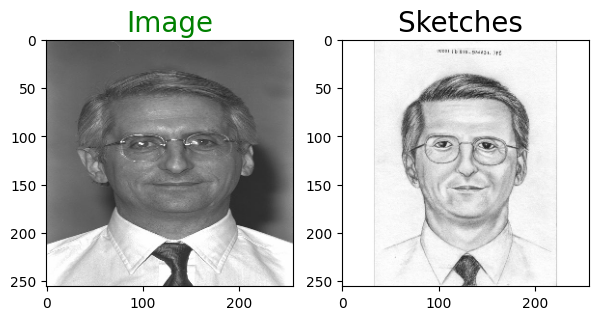

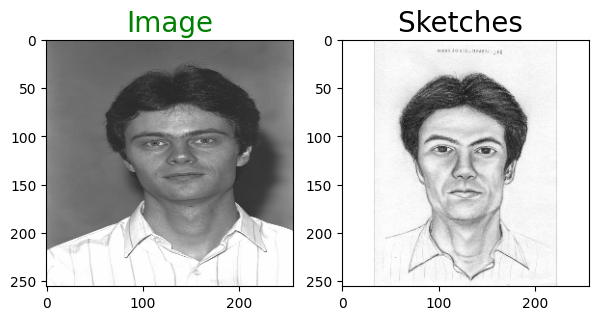

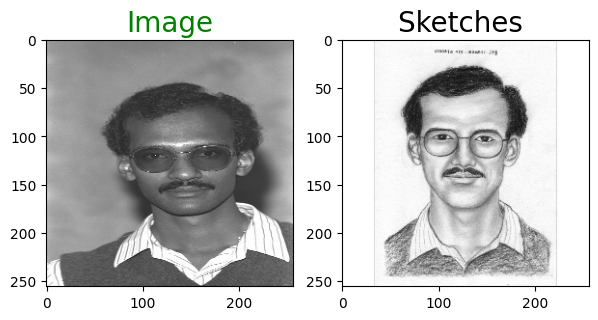

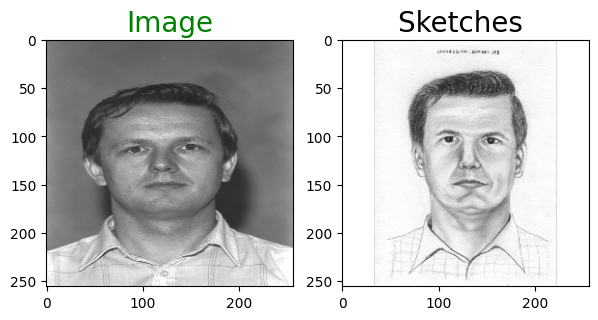

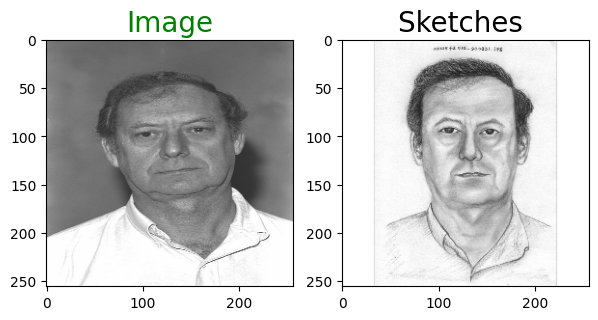

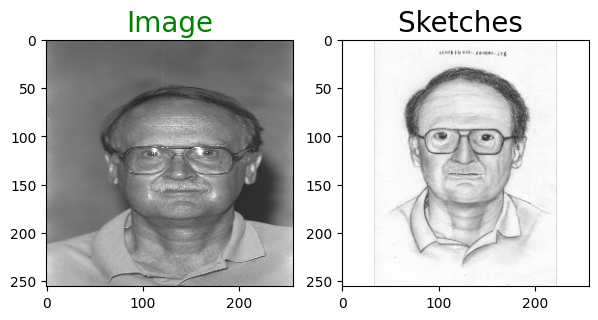

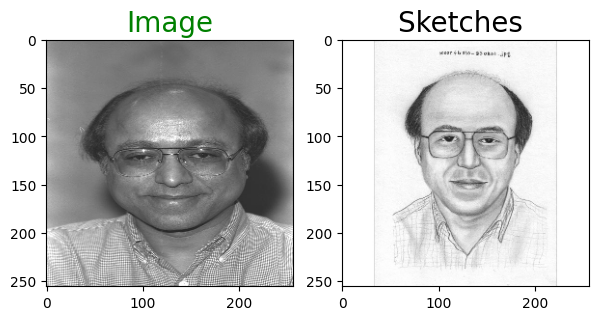

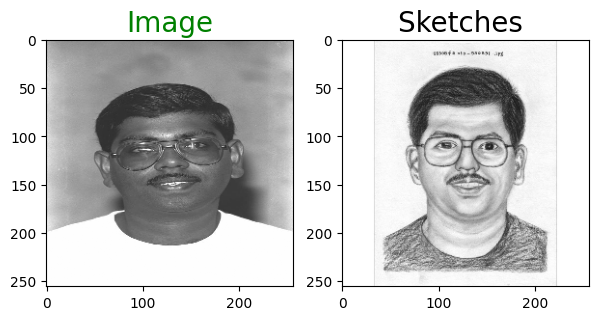

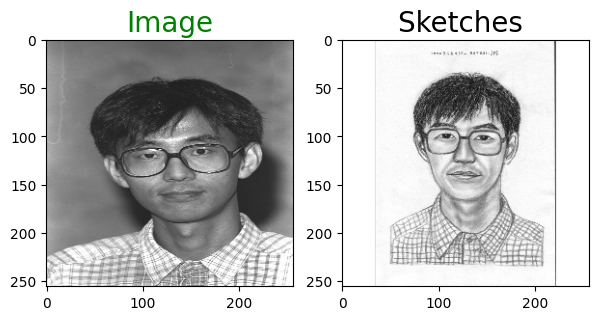

In [15]:
ls = [i for i in range(0,65,8)]
for i in ls:
    plot_images(img_array[i],sketch_array[i])

In [16]:
train_sketch_image = sketch_array[:1400]
train_image = img_array[:1400]
test_sketch_image = sketch_array[1400:]
test_image = img_array[1400:]
# reshaping
train_sketch_image = np.reshape(train_sketch_image,(len(train_sketch_image),SIZE,SIZE,3))
train_image = np.reshape(train_image, (len(train_image),SIZE,SIZE,3))
print('Train color image shape:',train_image.shape)
test_sketch_image = np.reshape(test_sketch_image,(len(test_sketch_image),SIZE,SIZE,3))
test_image = np.reshape(test_image, (len(test_image),SIZE,SIZE,3))
print('Test color image shape',test_image.shape)

Train color image shape: (1400, 256, 256, 3)
Test color image shape (5368, 256, 256, 3)


In [20]:
input_shape =  (SIZE, SIZE, 3)
latent_dim = 12

In [23]:
encoder_input = Input(shape=input_shape)

encoder_conv = Conv2D(filters=8, kernel_size=3, strides=2, padding='same', activation='relu')(encoder_input)

encoder_conv = Conv2D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(encoder_conv)
encoder_conv = keras.layers.LeakyReLU()(encoder_conv)

encoder_conv = Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')(encoder_conv)
encoder_conv = keras.layers.BatchNormalization()(encoder_conv)
encoder_conv = keras.layers.LeakyReLU()(encoder_conv)

encoder_conv = Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(encoder_conv)
encoder_conv = keras.layers.LeakyReLU()(encoder_conv)

encoder_conv = Conv2D(filters=128, kernel_size=3, strides=2, padding='same', activation='relu')(encoder_conv)
encoder_conv = keras.layers.BatchNormalization()(encoder_conv)
encoder_conv = keras.layers.LeakyReLU()(encoder_conv)

encoder_conv = Conv2D(filters=256, kernel_size=3, strides=2, padding='same', activation='relu')(encoder_conv)
encoder_conv = keras.layers.BatchNormalization()(encoder_conv)
encoder_conv = keras.layers.LeakyReLU()(encoder_conv)

encoder_conv = Conv2D(filters=512, kernel_size=3, strides=2, padding='same', activation='relu')(encoder_conv)
encoder_conv = keras.layers.BatchNormalization()(encoder_conv)
encoder_conv = keras.layers.LeakyReLU()(encoder_conv)

#re-run with keras.Flatten
encoder = keras.Flatten()(encoder_conv)

mu = Dense(latent_dim)(encoder)
sigma = Dense(latent_dim)(encoder)

In [25]:
def compute_latent(x):
    mu, sigma = x
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch,dim))
    return mu + K.exp(sigma/2)*eps

In [27]:

latent_space = Lambda(compute_latent, output_shape=(latent_dim,))([mu, sigma])

In [28]:
conv_shape = K.int_shape(encoder_conv)

In [29]:

conv_shape

(None, 2, 2, 512)

In [31]:

decoder_input = Input(shape=(latent_dim,))

decoder = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)

decoder = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(decoder)

decoder_conv = Conv2DTranspose(filters=512, kernel_size=3, strides=2, padding='same', activation='relu')(decoder)
decoder_conv = keras.layers.Dropout(0.1)(decoder_conv)
decoder_conv = keras.layers.LeakyReLU()(decoder_conv)

decoder_conv = Conv2DTranspose(filters=256, kernel_size=3, strides=2, padding='same', activation='relu')(decoder_conv)
decoder_conv = keras.layers.LeakyReLU()(decoder_conv)

decoder_conv = Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same', activation='relu')(decoder_conv)
decoder_conv = keras.layers.Dropout(0.1)(decoder_conv)
decoder_conv = keras.layers.LeakyReLU()(decoder_conv)

decoder_conv = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(decoder_conv)
decoder_conv = keras.layers.LeakyReLU()(decoder_conv)

decoder_conv = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')(decoder_conv)
decoder_conv = keras.layers.LeakyReLU()(decoder_conv)

decoder_conv = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(decoder_conv)
decoder_conv = keras.layers.LeakyReLU()(decoder_conv)

decoder_conv = Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding='same', activation='relu')(decoder_conv)

decoder_conv =  Conv2DTranspose(filters=3, kernel_size=3, padding='same', activation='sigmoid')(decoder_conv)

In [32]:

encoder = Model(encoder_input, latent_space)
decoder = Model(decoder_input, decoder_conv)

In [33]:
vae = Model(encoder_input, decoder(encoder(encoder_input)))

In [34]:
vae.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 model (Functional)          (None, 12)                1626600   
                                                                 
 model_1 (Functional)        (None, 256, 256, 3)       3959635   
                                                                 
Total params: 5,586,235
Trainable params: 5,584,379
Non-trainable params: 1,856
_________________________________________________________________


In [35]:
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_14 (Conv2D)             (None, 128, 128, 8)  224         ['input_5[0][0]']                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 64, 64, 16)   1168        ['conv2d_14[0][0]']              
                                                                                                  
 leaky_re_lu_12 (LeakyReLU)     (None, 64, 64, 16)   0           ['conv2d_15[0][0]']          

In [37]:
def kl_reconstruction_loss(true, pred):    # Reconstruction loss
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * SIZE * SIZE    
    
    # KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5    
    
    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)

In [38]:
vae.compile(optimizer='adam', loss=kl_reconstruction_loss)

In [48]:

history = vae.fit(x=train_image, y=train_sketch_image, epochs=250, batch_size=16, validation_data=(test_image,test_sketch_image))

Train on 1400 samples, validate on 5368 samples
Epoch 1/250
1400/1400 [==============================] - 69s 49ms/sample - loss: 18775.4666 - val_loss: 22432.5287
Epoch 2/250
1400/1400 [==============================] - 66s 47ms/sample - loss: 18783.4963 - val_loss: 22151.9195
Epoch 3/250
1400/1400 [==============================] - 65s 46ms/sample - loss: 18799.4644 - val_loss: 22207.3759
Epoch 4/250
1400/1400 [==============================] - 65s 47ms/sample - loss: 18733.6375 - val_loss: 22102.5058
Epoch 5/250
1400/1400 [==============================] - 66s 47ms/sample - loss: 18729.9788 - val_loss: 22384.1100
Epoch 6/250
1400/1400 [==============================] - 65s 46ms/sample - loss: 18706.6642 - val_loss: 22165.2441
Epoch 7/250
1400/1400 [==============================] - 65s 46ms/sample - loss: 18678.5521 - val_loss: 22261.0365
Epoch 8/250
1400/1400 [==============================] - 65s 47ms/sample - loss: 18627.8018 - val_loss: 22556.4733
Epoch 9/250
1400/1400 [=========

In [55]:
prediction_on_test_data = vae.evaluate(test_image, test_sketch_image)
print("Loss: ", prediction_on_test_data[0])
print("Accuracy: ", np.round(prediction_on_test_data[1] * 100,1))

IndexError: invalid index to scalar variable.

Text(0, 0.5, 'Loss')

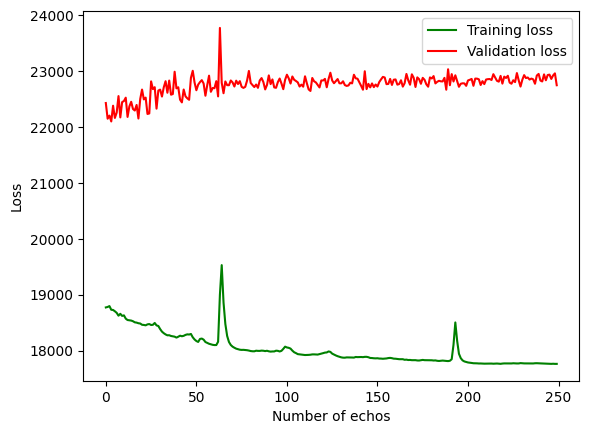

In [50]:
plt.plot(history.history['loss'], color='green')
plt.plot(history.history['val_loss'], color='red')
plt.legend(['Training loss', 'Validation loss'])
plt.xlabel('Number of echos')
plt.ylabel('Loss')

In [51]:
def show_images(real,sketch, predicted):
    plt.figure(figsize = (12,12))
    plt.subplot(1,3,1)
    plt.title("Image",fontsize = 15, color = 'Lime')
    plt.imshow(real)
    plt.subplot(1,3,2)
    plt.title("sketch",fontsize = 15, color = 'Blue')
    plt.imshow(sketch)
    plt.subplot(1,3,3)
    plt.title("Predicted",fontsize = 15, color = 'gold')
    plt.imshow(predicted)

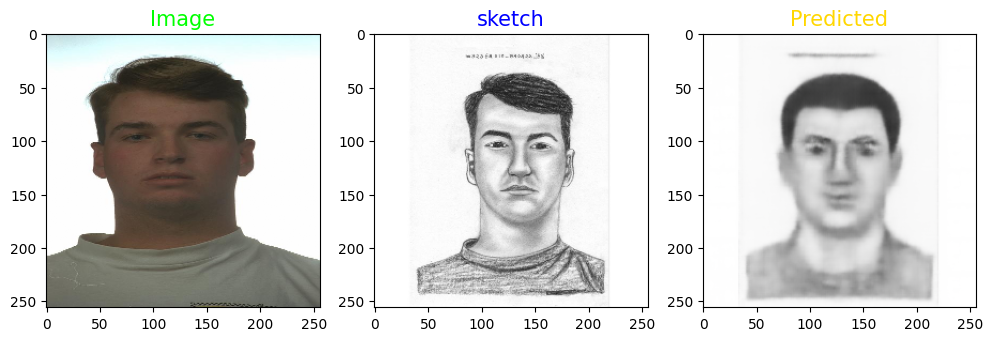

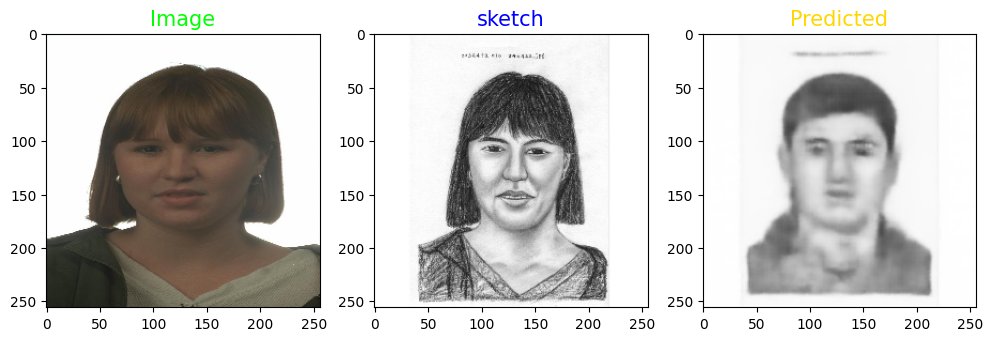

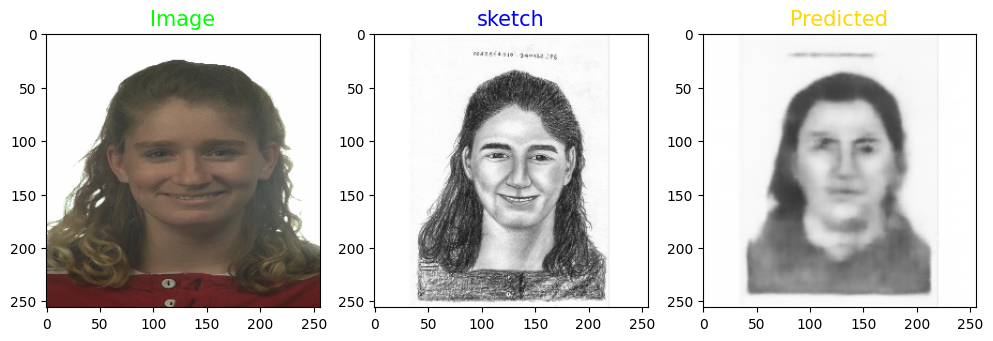

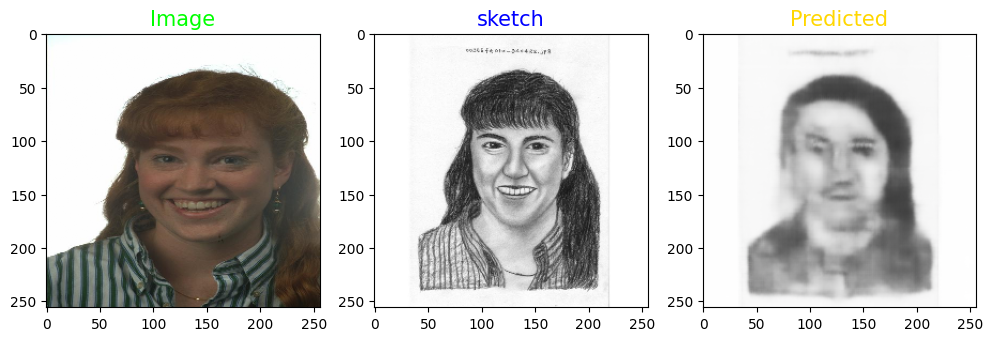

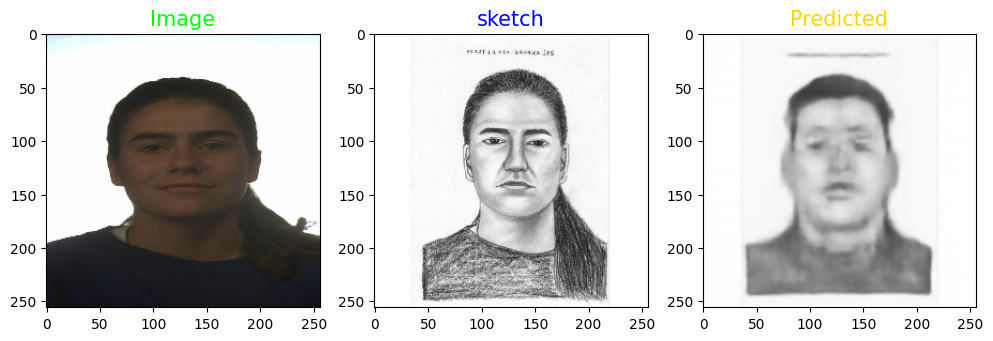

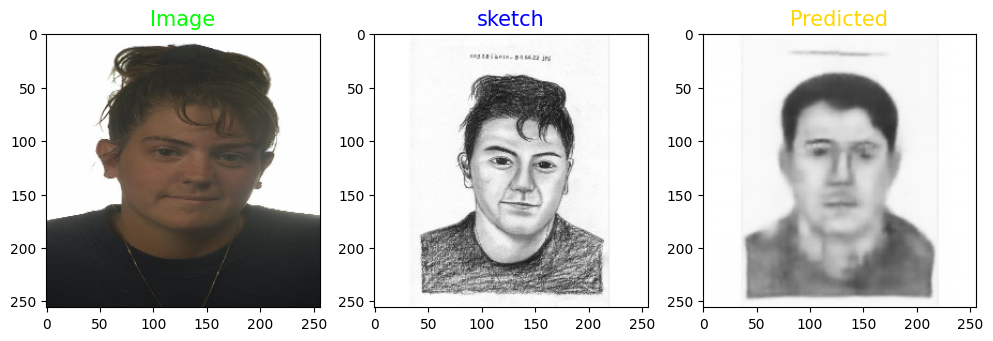

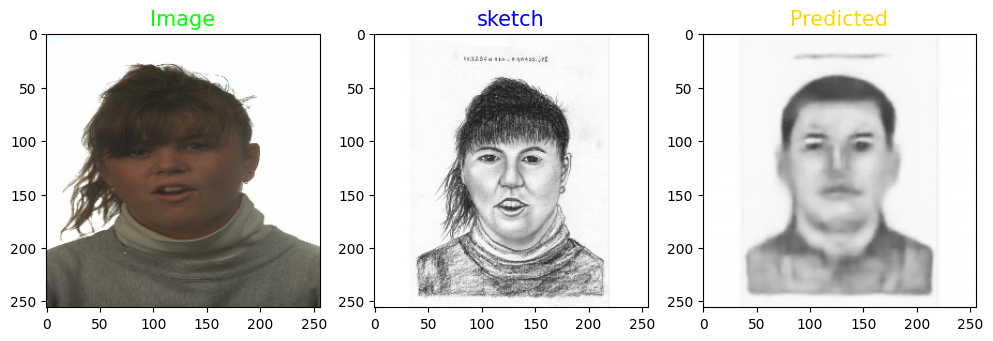

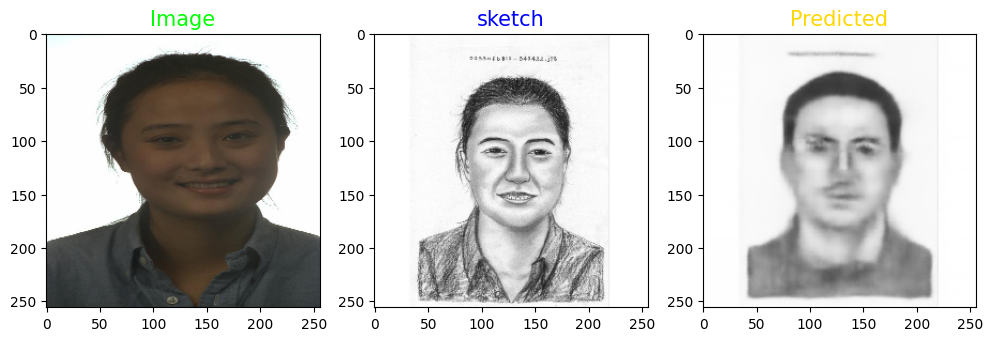

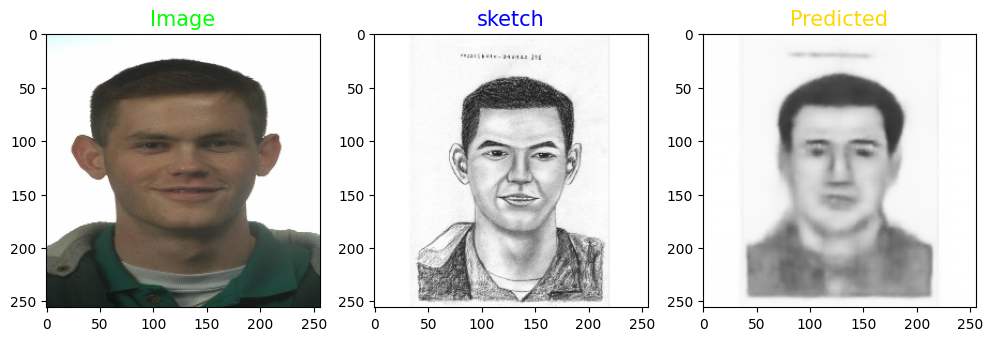

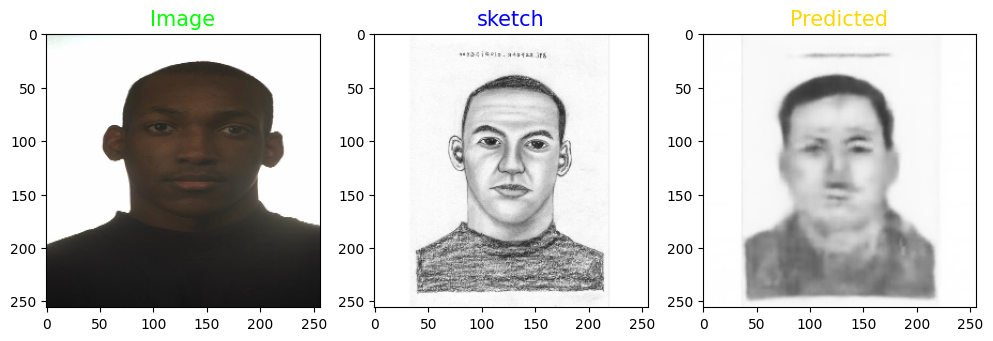

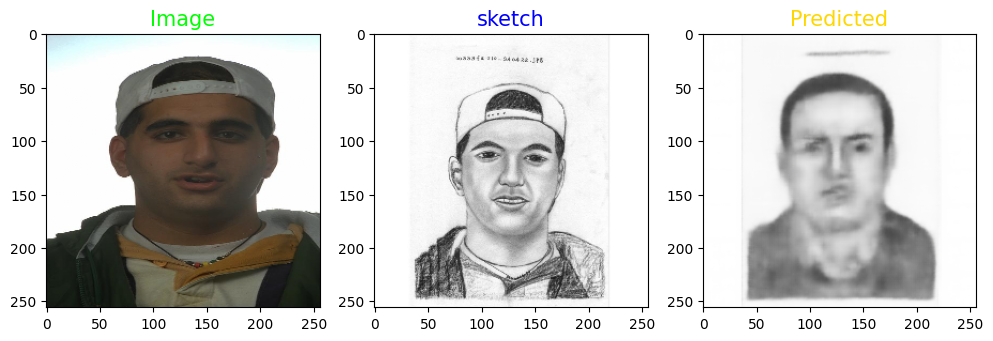

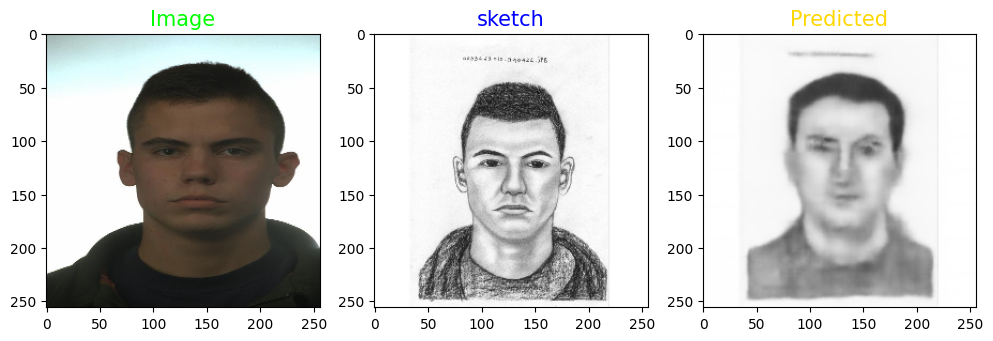

In [54]:
ls = [i for i in range(0,95,8)]
for i in ls:
    predicted =np.clip(vae.predict(test_image[i].reshape(1,SIZE,SIZE,3)),0.0,1.0).reshape(SIZE,SIZE,3)
    show_images(test_image[i],test_sketch_image[i],predicted)